In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
plt.style.use('dark_background')

GPUs=tf.config.list_physical_devices(device_type='GPU')
tf.config.experimental.get_device_details(GPUs[0])

{'device_name': 'NVIDIA GeForce RTX 3060', 'compute_capability': (8, 6)}

# Load data

In [30]:
# load contours
contours_dir=r'F:\Andy\Segmentation\20240110 halo col_glass incubator\contours\membrane-stage_1\smoothed_contours.pkl'
#contours_dir=r'PCA/JulyPDMS_stage21/smoothed_contours.pkl'

with open(contours_dir, 'rb') as file: 
    # Call load method to deserialze 
    contours = pickle.load(file) 
    
print(f'loaded {len(contours)} contours') 

loaded 127149 contours


In [36]:
from sklearn.model_selection import train_test_split
X=np.array([contour.points for contour in contours]) # read contours into an array

if X.mean(axis=1).max()>0.001: # rough check: this data isn't zeroed
    centroids=X.mean(axis=1)
    X=X-centroids.reshape(-1, 1, 2) # zero each contour's centroid

#scale_factor=1/(np.linalg.norm(X.reshape(-1,2), axis=1).std())
#X_scaled=np.array([contour.as_scaled(scale_factor).points for contour in contours]) # rescale contours by overall stdev of distance from center
# preprocessing. Definitely some way to do this properly with the keras pipeline but I don't want to figure it out rn.
#
scale_factor=X.std(axis=0) # std of all the coordinates? as a rescaling factor
X_scaled=X/scale_factor

X_train, X_valid = train_test_split(X_scaled, test_size=0.2)

100%|█████████████████████████████████████████████████████████████████████████| 67934/67934 [00:01<00:00, 49791.19it/s]


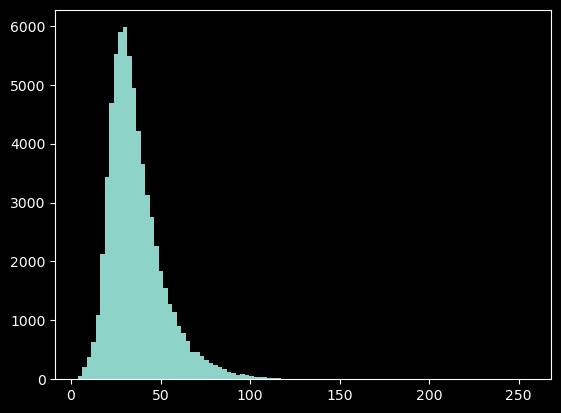

In [8]:
# sanity check: this preserves the size variance
def poly_area(outline):
    return 0.5*np.abs(np.dot(outline.T[0],np.roll(outline.T[1],1))-np.dot(outline.T[1],np.roll(outline.T[0],1)))

from tqdm import tqdm
areas=[]
for poly in tqdm(X_scaled):
    areas.append(poly_area(poly))
    
plt.hist(areas, bins=100)
plt.show()

# Initialize autoencoder

In [9]:
# autoencoder with tied weights - uses symmetry of the encoder/decoder to halve the number of parameters and get comparable results.
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

def tied_autoencoder(layer_size=200, n_layers=3, n_components=12):
    encoding_layers=[tf.keras.layers.Dense(layer_size, activation="relu") for n in range(n_layers-1)]
    encoding_layers.append(tf.keras.layers.Dense(n_components, activation="relu"))

    decoding_layers=[DenseTranspose(dense_layer, activation="relu") for dense_layer in reversed(encoding_layers[1:])]
    decoding_layers.append(DenseTranspose(encoding_layers[0]))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        *encoding_layers,
        #tf.keras.layers.ActivityRegularization(l1=1e-4)
    ])
    decoder = tf.keras.Sequential([
        *decoding_layers,
        tf.keras.layers.Reshape(X_train.shape[1:])
    ])
    
    autoencoder = tf.keras.Sequential([encoder, decoder])
    return autoencoder, encoder, decoder

n_components=12
autoencoder, encoder, decoder = tied_autoencoder(layer_size=200, n_layers=3, n_components=n_components)
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 12)                82812     
                                                                 
 sequential_1 (Sequential)   (None, 100, 2)            83412     
                                                                 
Total params: 83,412
Trainable params: 83,412
Non-trainable params: 0
_________________________________________________________________


## Load SavedModel

In [32]:
autoencoder=tf.keras.models.load_model('autoencoder/JanuaryColGlass/col_stage1_unaligned_autoencoder_model')
encoder, decoder = autoencoder.layers

# Train autoencoder

In [14]:
autoencoder.compile(loss="mse", optimizer='adam') # why are losses so low now?
history_1 = autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1699/1699 [==============================] - 9s 5ms/step - loss: 0.0280 - val_loss: 0.0278
Epoch 2/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0288 - val_loss: 0.0281
Epoch 3/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0277 - val_loss: 0.0276
Epoch 4/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0275 - val_loss: 0.0285
Epoch 5/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0273 - val_loss: 0.0273
Epoch 6/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0272 - val_loss: 0.0278
Epoch 7/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0271 - val_loss: 0.0273
Epoch 8/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0270 - val_loss: 0.0266
Epoch 9/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.0269 - val_loss: 0.0267
Epoch 10/10
1699/1699 [==============================] - 8s 5ms/step - loss: 0.026

# Interpret the encoder and decoder

In [11]:
def plot_reconstructions(model, contours=X_valid, n_contours=5):
    reconstructions=model.predict(contours[:n_contours])
    fig = plt.figure(figsize=(n_contours * 1.5, 3))
    for contour_index in range(n_contours):
        plt.subplot(2, n_contours, 1 + contour_index, aspect='equal')
        plot_contour(contours[contour_index])
        plt.axis("off")
        plt.subplot(2, n_contours, 1 + n_contours + contour_index, aspect='equal')
        plot_contour(reconstructions[contour_index])
        plt.axis("off")

def plot_contour(points, ax=None, s=1, cmap='plasma', **kwargs):
    if not ax: ax=plt.gca()
    ax.scatter(*points.T, s=s, c=np.linspace(0.2, 1, len(points)), cmap=cmap)

1/1 [==============================] - 0s 61ms/step


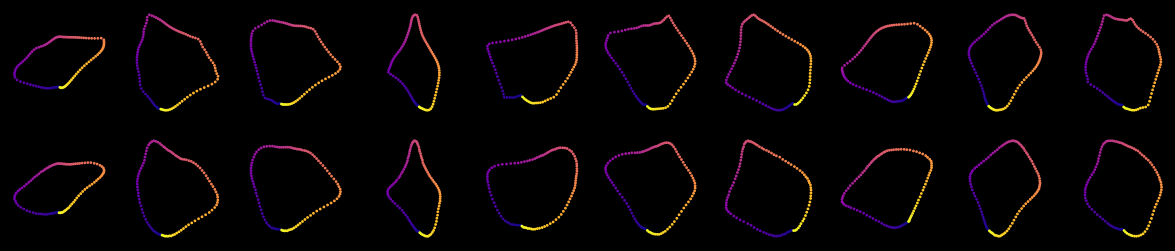

In [33]:
plot_reconstructions(autoencoder, contours=X_valid, n_contours=10)
#plt.savefig('stage21_unaligned__reconstructions.jpg', dpi=300)

In [37]:
X_valid_encoded=encoder.predict(X_valid)
mean_encoding=X_valid_encoded.mean(axis=0)
std_encoding=X_valid_encoded.std(axis=0)
mean_contour=decoder.predict(np.array([mean_encoding]))[0]

1/1 [==============================] - 0s 14ms/step


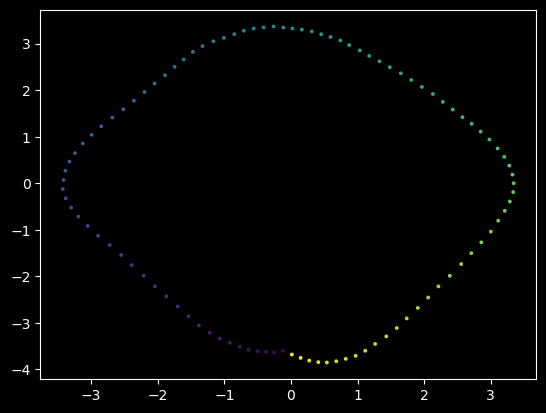

In [18]:
plot_contour(mean_contour, s=3, cmap='viridis')
plt.savefig('stage21_unaligned_autoencoder_mean.jpg', dpi=300)

2/2 [==============================] - 0s 8ms/step


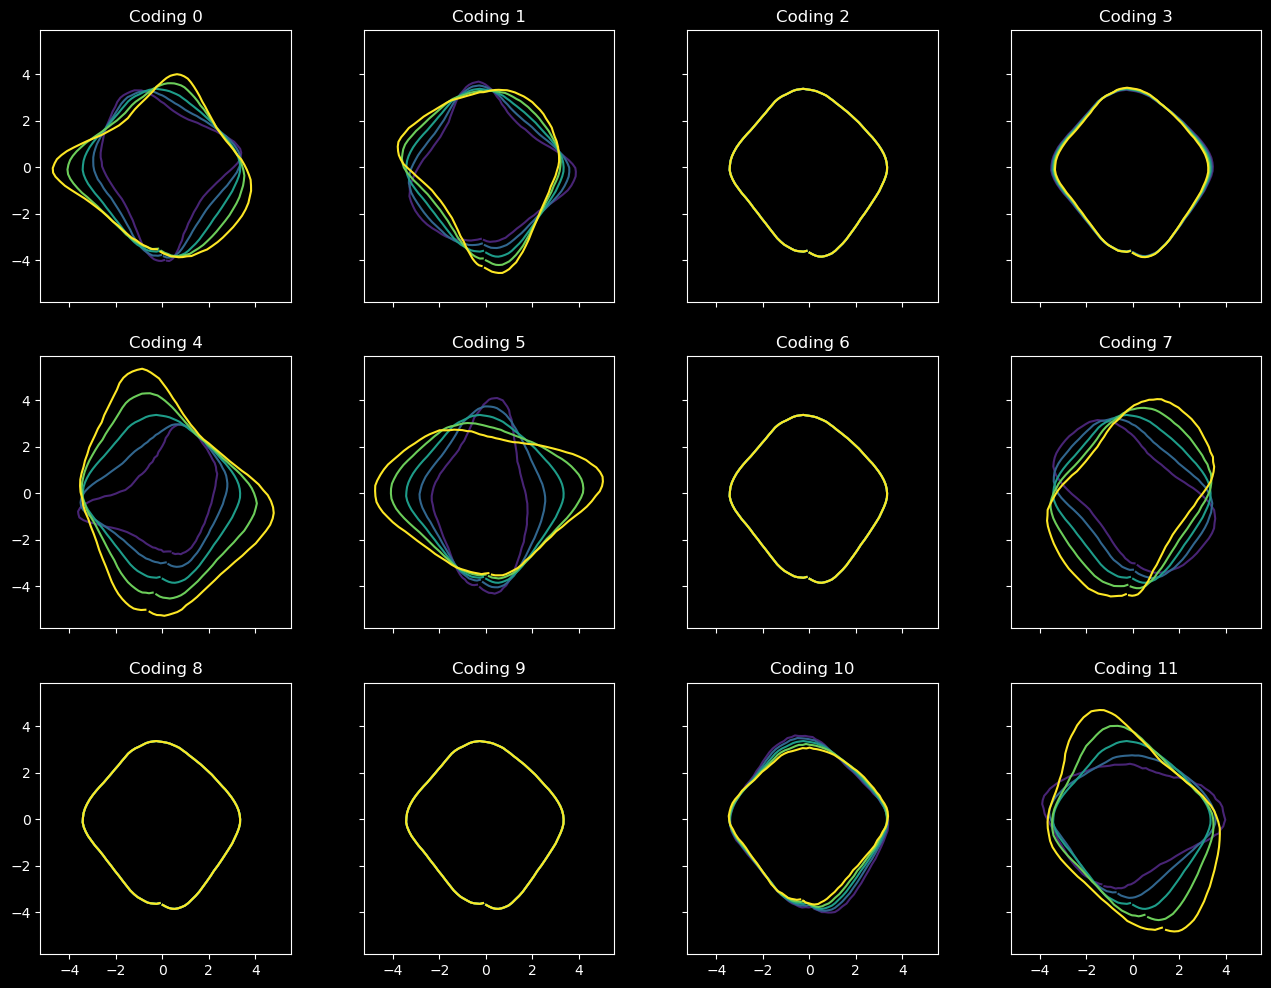

In [24]:
# num_nodes=8
positions=[-2,-1,0,1,2]
colors=plt.cm.viridis(np.linspace(0.1,1,len(positions)))

fig, axes=plt.subplots(3,4,figsize=(16,12), sharex=True, sharey=True, subplot_kw={'aspect':'equal'})
contour_encodings=[]
for n, stdev in enumerate(std_encoding):
    node_contour_encodings=[]
    for color, position in zip(colors, positions):
        stdev_contour_encoded=mean_encoding.copy()
        stdev_contour_encoded[n]+=stdev*position
        node_contour_encodings.append(stdev_contour_encoded)
    contour_encodings.append(node_contour_encodings)

contour_encodings=np.array(contour_encodings)
stdev_contours=decoder.predict(contour_encodings.reshape(-1, n_components)).reshape(-1, len(positions), 100, 2)

for n, (contours, ax) in enumerate(zip(stdev_contours, axes.flatten())):
    ax.set_title(f'Coding {n}')
    for stdev_contour, color in zip(contours, colors):
        ax.plot(*stdev_contour.T, color=color)
        
plt.savefig('stage21_unaligned_autoencoder_modes.jpg', dpi=300)

2/2 [==============================] - 0s 0s/step


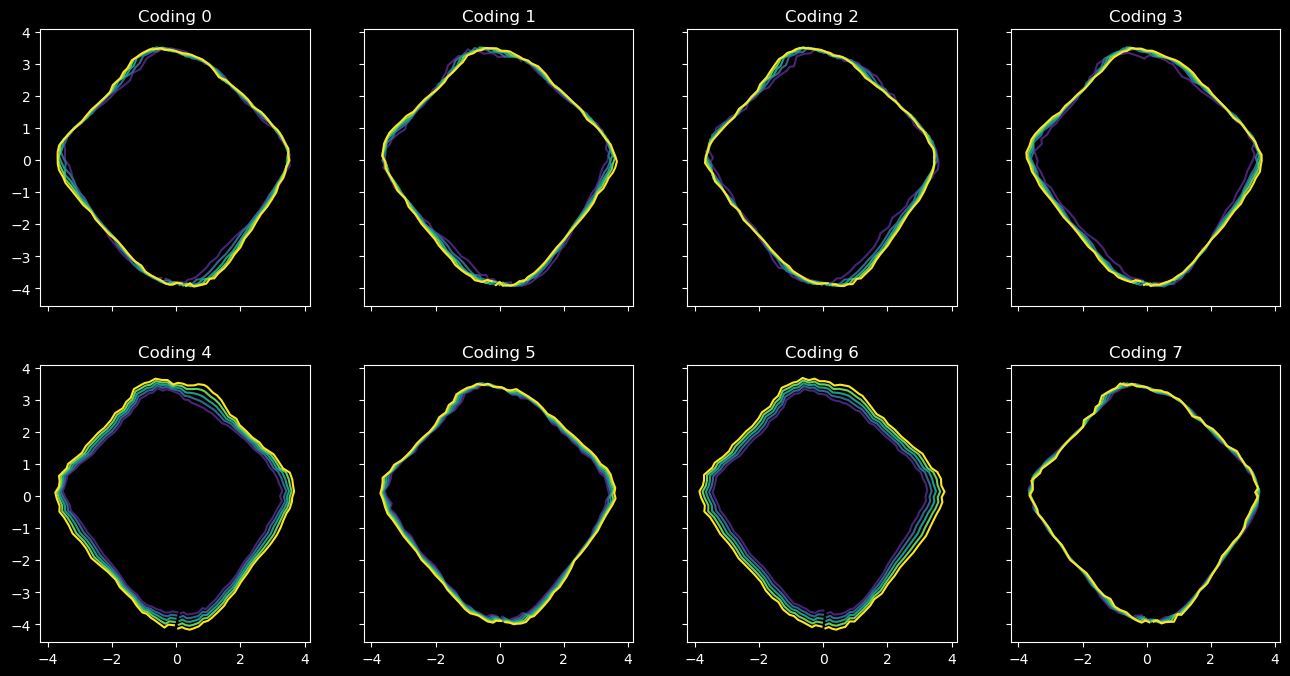

In [193]:
# many encoding nodes, pick the most utilized
top_node_means=np.flip(X_valid_encoded.mean(axis=0).argsort()[-8:])
top_node_stds=np.flip(X_valid_encoded.std(axis=0).argsort()[-8:])

positions=[-2,-1,0,1,2]
colors=plt.cm.viridis(np.linspace(0.1,1,len(positions)))

fig, axes=plt.subplots(2,4,figsize=(16,8), sharex=True, sharey=True, subplot_kw={'aspect':'equal'})
contour_encodings=[]
for n in top_node_stds:
    node_contour_encodings=[]
    stdev=std_encoding[n]
    for color, position in zip(colors, positions):
        stdev_contour_encoded=mean_encoding.copy()
        stdev_contour_encoded[n]+=stdev*position
        node_contour_encodings.append(stdev_contour_encoded)
    contour_encodings.append(node_contour_encodings)

contour_encodings=np.array(contour_encodings)
stdev_contours=tied_decoder.predict(contour_encodings.reshape(-1, n_components)).reshape(-1, len(positions), 100, 2)

for n, (contours, ax) in enumerate(zip(stdev_contours, axes.flatten())):
    ax.set_title(f'Coding {n}')
    for stdev_contour, color in zip(contours, colors):
        ax.plot(*stdev_contour.T, color=color)

## Export autoencoder to SavedModel format

In [ ]:
autoencoder.save('stage21_unaligned_autoencoder', save_format='tf')

# PCA on encoded outputs

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca.fit(X_valid_encoded)

print(f'Data has {pca.n_features_in_} features')
print(f'PCA model has {pca.n_components_} components to explain 95% of data variance')
print(f'Cumulative Explained Variance: {np.cumsum(pca.explained_variance_ratio_)}')

Data has 12 features
PCA model has 6 components to explain 95% of data variance
Cumulative Explained Variance: [0.42922297 0.72593105 0.83502203 0.90912133 0.93686336 0.96173507]


1/1 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'Mean Contour, PCA of Encodings')

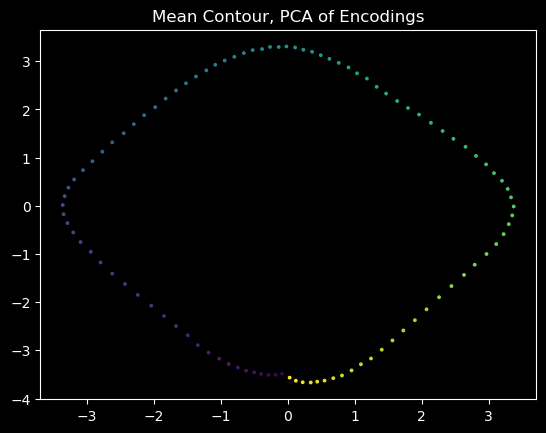

In [41]:
mean_PCA_contour=decoder.predict(np.array([pca.mean_]))[0]
plt.scatter(*mean_PCA_contour.T, c=np.linspace(0,1,len(mean_PCA_contour)), s=3, cmap='viridis')
plt.title('Mean Contour, PCA of Encodings')

1/1 [==============================] - 0s 10ms/step


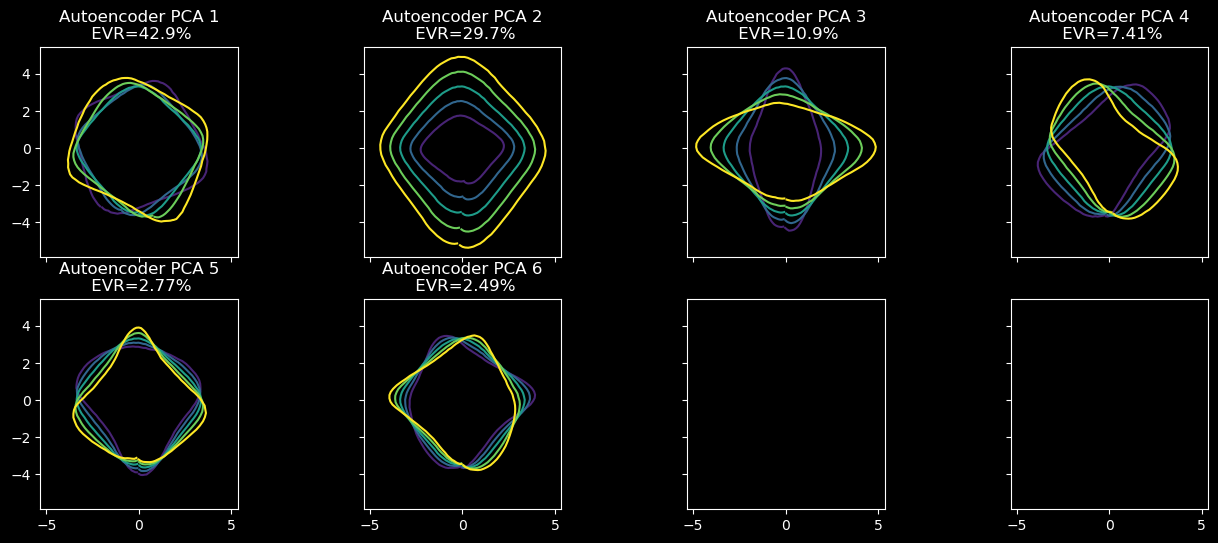

In [44]:
# num_nodes=8
positions=[-2,-1,0,1,2]
colors=plt.cm.viridis(np.linspace(0.1,1,len(positions)))

fig, axes=plt.subplots(2,4,figsize=(16,6), sharex=True, sharey=True, subplot_kw={'aspect':'equal'})
contour_encodings=[]
for n, component in enumerate(pca.components_):
    node_contour_encodings=[]
    for color, position in zip(colors, positions):
        stdev_contour_encoded=pca.mean_.copy()
        stdev=np.sqrt(pca.explained_variance_[n])
        stdev_contour_encoded+=stdev*component*position
        node_contour_encodings.append(stdev_contour_encoded)
    contour_encodings.append(node_contour_encodings)

contour_encodings=np.array(contour_encodings)
stdev_contours=decoder.predict(contour_encodings.reshape(-1, n_components)).reshape(-1, len(positions), 100, 2)

for n, (contours, ax) in enumerate(zip(stdev_contours, axes.flatten())):
    ax.set_title(f'Autoencoder PCA {n+1}\n EVR={pca.explained_variance_ratio_[n]*100:.3g}%')
    for stdev_contour, color in zip(contours, colors):
        ax.plot(*stdev_contour.T, color=color)

#fig.tight_layout()
#plt.savefig('col_stage1_unaligned_PCA_autoencoder_modes.jpg', dpi=300)

1/1 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'Autoencoder-PCA transformations in sequence')

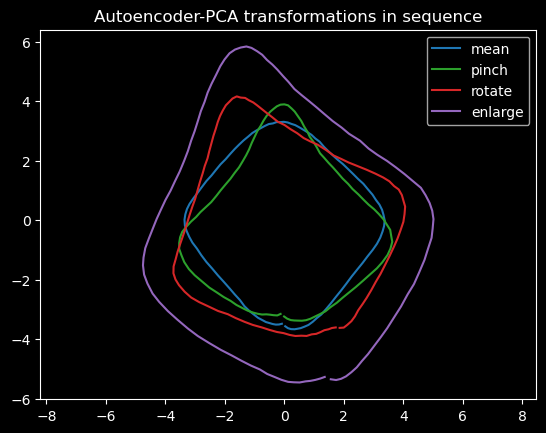

In [74]:
rotate_and_elongate=pca.mean_.copy()
outline=decoder.predict(np.array([rotate_and_elongate]))
plt.plot(*outline.T, label='mean', color=plt.cm.tab10(0))

rotate_and_elongate+=2*pca.components_[4]*np.sqrt(pca.explained_variance_[4]) # elongate
outline=decoder.predict(np.array([rotate_and_elongate]))
plt.plot(*outline.T, label='pinch', color=plt.cm.tab10(2))

rotate_and_elongate+=2*pca.components_[0]*np.sqrt(pca.explained_variance_[0]) # rotate

outline=decoder.predict(np.array([rotate_and_elongate]))
plt.plot(*outline.T, label='rotate', color=plt.cm.tab10(3))

rotate_and_elongate+=2*pca.components_[1]*np.sqrt(pca.explained_variance_[1]) # enlarge

outline=decoder.predict(np.array([rotate_and_elongate]))

plt.plot(*outline.T, label='enlarge', color=plt.cm.tab10(4))

plt.legend()
plt.axis('equal')
plt.title('Autoencoder-PCA transformations in sequence')